In [1]:
from glob import glob
import json
import os
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib ipympl

## Functions

In [5]:
def prune_close_peaks(peak_times, peak_amplitudes, minimum_peak_separation=0.08):
    """
    This function is designed to remove extra peaks that are marking the same SWD spike due to varying voltage around the spike.

    Inputs:
    ----------
    peak_times : array_like
        An array/list of peak times.
    peak_amplitudes : array_like
        An array/list of peak amplitudes, must be positive amplitudes.
    minimum_peak_separation : float, default=0.08
        The minimum time separation (s) you would expect to find consecutive spikes in the SWD. Peaks that are found with intervals less than this
        are grouped and pruned to the one peak with the maximum amplitude.

    Outputs:
    ----------
    pruned_peak_times : array
        An array of peak times after removing double+ peaks.
    """
    pruned_peak_times = []
    # Start first group
    close_times = [peak_times[0]]
    close_amps  = [peak_amplitudes[0]]
    for t, a in zip(peak_times[1:], peak_amplitudes[1:]):
        # If this peak is close to the previous one, group it
        if t - close_times[-1] < minimum_peak_separation:
            close_times.append(t)
            close_amps.append(a)
        else:
            # Commit the max-amplitude peak of the previous group
            idx = np.argmax(close_amps)
            pruned_peak_times.append(close_times[idx])
            # Start new group
            close_times = [t]
            close_amps  = [a]
    # Commit last group
    idx = np.argmax(close_amps)
    pruned_peak_times.append(close_times[idx])
    return np.array(pruned_peak_times)

def group_peaks(swd_spike_times, initial_ISI_threshold=0.2, other_ISI_threshold=0.35):
    """
    This function groups peaks into potential SWD events based on the following criteria:
        - the first two spikes in an event have an ISI < initial_ISI_threshold (McCafferty et al. used 0.2 s)
        - any other spikes in the event have ISI < other_ISI_threshold (McCafferty et al. used 0.35 s)

    Inputs:
    ----------
    swd_spike_times : array_like
        An array/list of peak times.
    initial_ISI_threshold : float, default=0.2
        The maximum time separation (s) between the first two spikes in the SWD.
    other_ISI_threshold : float, default=0.35
        The maximum time separation (s) between the remaining spikes in the SWD.

    Outputs:
    ----------
    grouped_spikes : list
        A list of events, each of which is list of SWD spike times that meet the ISI criteria.
    """
    grouped_spikes = []
    temp_group = [swd_spike_times[0]]
    for t in swd_spike_times[1:]:
        if (len(temp_group) == 1) and (t - temp_group[-1] < initial_ISI_threshold): # if this is the second spike in SWD, use initial threshold
            temp_group.append(t)
        elif (len(temp_group) > 1) and (t - temp_group[-1] < other_ISI_threshold): # if this is the third+ spike in SWD, use relaxed threshold
            temp_group.append(t)
        else:
            grouped_spikes.append(temp_group) # if the spike ISI is greater than threshold, add group to event list
            temp_group = [t] # start the next possible event with this spike time
    grouped_spikes.append(temp_group) # add the final group
    return grouped_spikes

def events_to_SWDdf(possible_events, event_separation_threshold=0.5, minimum_spikes=5, minimum_SWD_duration=0.5):
    """
    This function sorts through potential SWD events. It combines events if they are closer in time than event_separation_threshold. If the number of
    spikes in the SWD is less than minimum_spikes or the SWD duration is less than minimum_SWD_duration, remove them from the list. Then turn the list
    into a pandas.DataFrame with the following event info: onset, offset, duration, spike_count, SWD_spike_times.

    Inputs:
    ----------
    possible_events : list
        A list of events, each of which is list of SWD spike times.
    event_separation_threshold : float, default=0.5
        If the time between two consecutive SWD events is less than event_separation_threshold, combine the two events.
    minimum_spikes : int, default=5
        Subselect SWD events that have at least minimum_spikes.
    minimum_SWD_duration : float, default=0.5
        Subselect SWD events that have a duration > minimum_SWD_duration.

    Outputs:
    ----------
    SWDdf : pandas.DataFrame
        Contains the SWD events that pass the above criteria and the following info: onset, offset, duration, spike_count, SWD_spike_times.
    """
    prune_events = []
    temp_combo = possible_events[0]
    for eventi in possible_events[1:]:
        if eventi[0] - temp_combo[-1] < event_separation_threshold: # if consecutive temp events are <0.5 s apart, combine them
            temp_combo.extend(eventi)
        else:
            if len(temp_combo) >= minimum_spikes: # if the event has enough spikes, keep the event
                prune_events.append(temp_combo)
            temp_combo = eventi # if consecutive temp events are >0.5 s apart, reset the temp event
    if len(temp_combo) >= minimum_spikes: # if the event has enough spikes, keep the event
        prune_events.append(temp_combo)
    SWD_info = []
    for eventi in prune_events:
        if eventi[-1] - eventi[0] > minimum_SWD_duration:
            SWD_info.append([eventi[0], eventi[-1], eventi[-1]-eventi[0], len(eventi), eventi])
    return pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])

In [6]:
def get_SWD_events(data, data_ts, data_sample_rate, stim_log=None, firstpass_std_multiple=1.5, secondpass_std_multiple=2.0):
    """
    This function is designed find SWD events on a given voltage signal (mainly EEG or LFP). It performs two rounds of peak finding: the first using 
    a relatively lenient threshold (using the mean + 1.5 * std of the first 5 min of recording); and the second pass uses a slightly stricter criteria
    (using the mean + 2 * std of the quiescent part of the recording, after removing stim times and possible SWDs identified in the first pass).

    Inputs:
    ----------
    data : array
        A 1-D array containing the data signal used to extract the SWD events.
    data_ts : array
        A 1-D array containing the timestamps (s) associated with the data_signal.
    data_sample_rate : float
        The sample rate for the data.
    stim_log : pandas.DataFrame
        A dataframe containing stimulus trial information, to exclude stimulus bouts from the pekak finding threshold.
    firstpass_std_multiple : float, default=1.5
        The multiplier for the standard deviation to set the first-pass peak threshold.
    secondpass_std_multiple : float, default=2.0
        The multiplier for the standard deviation to set the second-pass peak threshold.

    Outputs:
    ----------
    SWD_df : pandas.DataFrame
        An array of peak times after removing double+ peaks.
    """
    ### Set parameters ###
    smooth_time = 0.001 # in s, McCafferty uses +/-10 ms
    DC_subtraction_time = 0.1 # in s, McCafferty uses [-0.1, +0.11] s
    firstpass_window = [0, 300] # in s, window to get first-pass peak threshold
    
    ### First apply smoothing using a rolling average ###
    smooth_samples = int(smooth_time * data_sample_rate * 2)
    clean_data = signal.filtfilt(b=np.ones(smooth_samples) / smooth_samples, a=[1], x=data)
    ### Next apply DC subtraction using a rolling average over a wider window ###
    DC_samples = int(DC_subtraction_time * data_sample_rate * 2)
    DC_average = signal.filtfilt(b=np.ones(DC_samples) / DC_samples, a=[1], x=clean_data)
    clean_data = clean_data - DC_average

    ### Perform first-pass peak finding ###
    data_slice = clean_data[np.nonzero((data_ts > data_ts[0] + firstpass_window[0]) & (data_ts < data_ts[0] + firstpass_window[1]))[0]]
    first_peak_threshold = np.mean(data_slice) + (firstpass_std_multiple * np.std(data_slice))
    firstpass_peaks, _ = signal.find_peaks(-clean_data, first_peak_threshold)
    ## Prune the double+ peaks and get possible events ##
    firstpass_peaks = prune_close_peaks(data_ts[firstpass_peaks], -(clean_data[firstpass_peaks]))
    possible_SWD_events = group_peaks(firstpass_peaks)

    ### Use first-pass events to remove possible SWDs and stim times ###
    quiescent_data = clean_data.copy()
    ## Remove stim sessions from signal ##
    if stim_log is not None:
        for sweepi in np.unique(stim_log.sweep.values):
            sweepdf = stim_log[stim_log['sweep'] == sweepi]
            for stimtype in np.unique(sweepdf.stim_type.values):
                stimdf = sweepdf[sweepdf['stim_type'] == stimtype]
                stiminds = np.nonzero((data_ts > stimdf.onset.values[0]) & (data_ts < stimdf.offset.values[-1]))[0]
                quiescent_data[stiminds] = np.nan
    ## Remove possible SWDs from signal ##
    for spikelist in possible_SWD_events:
        if len(spikelist) > 2: # selects possible events with more than 2 peaks
            eventinds = np.nonzero((data_ts > spikelist[0] - 0.2) & (data_ts < spikelist[-1] + 0.2))[0] # buffer possible SWD by 0.2 s before/after
            quiescent_data[eventinds] = np.nan

    ### Perform second-pass peak finding ###
    second_peak_threshold = np.nanmean(quiescent_data) + (secondpass_std_multiple * np.nanstd(quiescent_data))
    secondpass_peaks, _ = signal.find_peaks(-clean_data, second_peak_threshold)
    ## Prune the double+ peaks and get possible events ##
    secondpass_peaks = prune_close_peaks(data_ts[secondpass_peaks], -(clean_data[secondpass_peaks]))
    possible_SWD_events = group_peaks(secondpass_peaks)
    return events_to_SWDdf(possible_SWD_events), clean_data

## Load experiment

In [7]:
recfolder = r'E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_estim_2023-07-13_13-28-01\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
print(eeg_ts[0])
print(eeg_ts[-1])

79.3536544827942
6682.103505585035


#### Load stim log, if applicable

In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # print(stim_log.head())
else:
    stim_log = None
    print('No stim log found.')

## Testing main function

In [38]:
test_ch = 13
startt = time.time()
SWD_df, cleaned_data = get_SWD_events(
    eeg_data[:, test_ch], eeg_ts, exp.ephys_params['EEG']['sample_rate'], stim_log=stim_log, firstpass_std_multiple=1.5, secondpass_std_multiple=2.5
)
endt = time.time()
print('Time to process SWDs: {:.2f} s'.format(endt-startt))

Time to process SWDs: 110.98 s


In [27]:
print(len(SWD_df))

1623


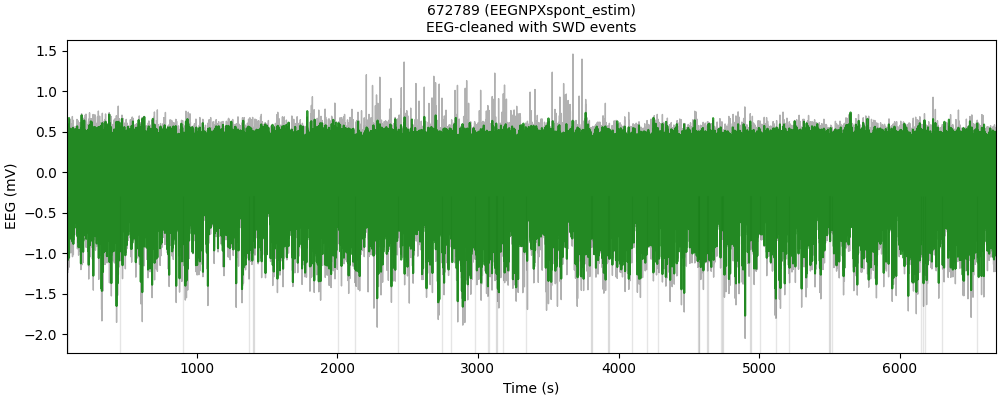

In [43]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(eeg_ts, eeg_data[:,test_ch], color='k', linewidth=1.0, alpha=0.3)
ax.plot(eeg_ts, cleaned_data, color='g', linewidth=1.5, alpha=0.8)
ax.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-cleaned with SWD events'.format(exp.mouse, exp_tag))
for dfind, dfrow in SWD_df.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0, 0.5, color='k', alpha=0.1)

In [22]:
for dfind, dfrow in SWD_df.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1.0, color='c', alpha=0.1)

In [23]:
print(len(SWD_df))

881


Test the effect of changing the second std multiple on SWD annotation

In [42]:
test_ch = 13
pk_thresholds = np.arange(1.5, 3.5, 0.25)
for pk_thi in pk_thresholds:
    SWD_df, _ = get_SWD_events(
        eeg_data[:, test_ch], eeg_ts, exp.ephys_params['EEG']['sample_rate'], stim_log=stim_log,
        firstpass_std_multiple=1.5, secondpass_std_multiple=pk_thi
    )
    print('For {:.2f}*std threshold: {:d} SWDs'.format(pk_thi, len(SWD_df)))

For 1.5*std threshold: 949 SWDs
For 1.8*std threshold: 1502 SWDs
For 2.0*std threshold: 1623 SWDs
For 2.2*std threshold: 1252 SWDs
For 2.5*std threshold: 744 SWDs
For 2.8*std threshold: 300 SWDs
For 3.0*std threshold: 110 SWDs
For 3.2*std threshold: 37 SWDs


array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

### Test main function on LFP

In [18]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

['probeB', 'probeC', 'probeD', 'probeF']


In [29]:
probe_name = 'probeF'
## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

area_chs = np.nonzero(probe_areas == 'MOp2/3')[0]
print(area_chs)

[298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338]


In [34]:
lfp_ch = 350
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))
lfp_raw_data = lfp_data_mm[:, lfp_ch] * exp.ephys_params[probe_name]['bit_volts']

In [35]:
startt = time.time()
SWD_df_lfp, cleaned_lfp_data = get_SWD_events(
    lfp_raw_data, lfp_ts, exp.ephys_params[probe_name]['lfp_sample_rate'], stim_log=stim_log, firstpass_std_multiple=1.5, secondpass_std_multiple=2.0
)
endt = time.time()
print('Time to process SWDs: {:.2f} s'.format(endt-startt))

Time to process SWDs: 97.76 s


In [36]:
print(len(SWD_df_lfp))

1597


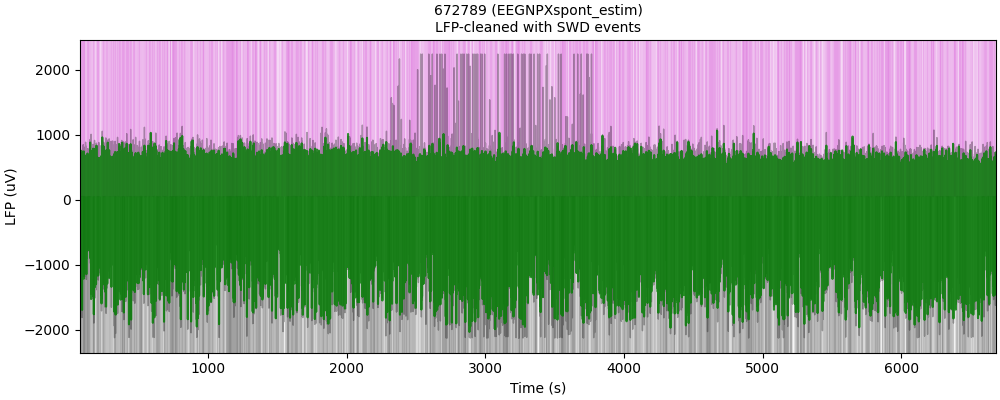

In [37]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(lfp_ts, lfp_raw_data, color='k', linewidth=1.0, alpha=0.3)
ax.plot(lfp_ts, cleaned_lfp_data, color='g', linewidth=1.5, alpha=0.8)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('LFP (uV)')
ax.set_title('{} ({})\nLFP-cleaned with SWD events'.format(exp.mouse, exp_tag))
for dfind, dfrow in SWD_df_lfp.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1.0, color='m', alpha=0.1)
for dfind, dfrow in SWD_df.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0, 0.5, color='k', alpha=0.1)

## Testing individual functions

#### Testing preprocessing procedure from McCafferty et al. 2023 (smoothing and DC removal instead of filtering)

First apply smoothing using +/-10 ms window

In [12]:
smoothing_time = 0.001 # in s, McCafferty uses +/-10 ms
total_smoothing_samples = int(smoothing_time * exp.ephys_params['EEG']['sample_rate'] * 2)
print(total_smoothing_samples)

5


In [13]:
test_ch = 20
smoothed_eeg = signal.filtfilt(b=np.ones(total_smoothing_samples) / total_smoothing_samples, a=[1], x=eeg_data[:,test_ch])

Next, apply DC removal using [-0.1, +0.11] s window

In [14]:
DC_samples = int(0.1 * exp.ephys_params['EEG']['sample_rate'] * 2)
print(DC_samples)

500


In [15]:
DC_smooth_eeg = smoothed_eeg - signal.filtfilt(b=np.ones(DC_samples) / DC_samples, a=[1], x=smoothed_eeg)

#### Next, they set the peak threshold to mean(baseline non-SWD cleaned EEG) - [5-7] * std(baseline non-SWD cleaned EEG)

First pass without excluding any SWDs

In [19]:
testslice = [0, 300]
slice_inds = np.nonzero((eeg_ts > eeg_ts[0] + testslice[0]) & (eeg_ts < eeg_ts[0] + testslice[1]))[0]
smdataslice = DC_smooth_eeg[slice_inds]

In [21]:
std_mult = 1.5
sm_data_thresh = np.mean(smdataslice) + (std_mult * np.std(smdataslice))
print('Smoothed data threshold: {:.2f} mV'.format(sm_data_thresh))

Smoothed data threshold: 0.22 mV


In [23]:
## Find the first round of peaks ##
pks_smdata, _ = signal.find_peaks(-DC_smooth_eeg, sm_data_thresh)
print(len(pks_smdata))
## Prune the double+ peaks ##
pruned_pk_times = prune_close_peaks(eeg_ts[pks_smdata], -(DC_smooth_eeg[pks_smdata]))
print(len(pruned_pk_times))

26314
14152


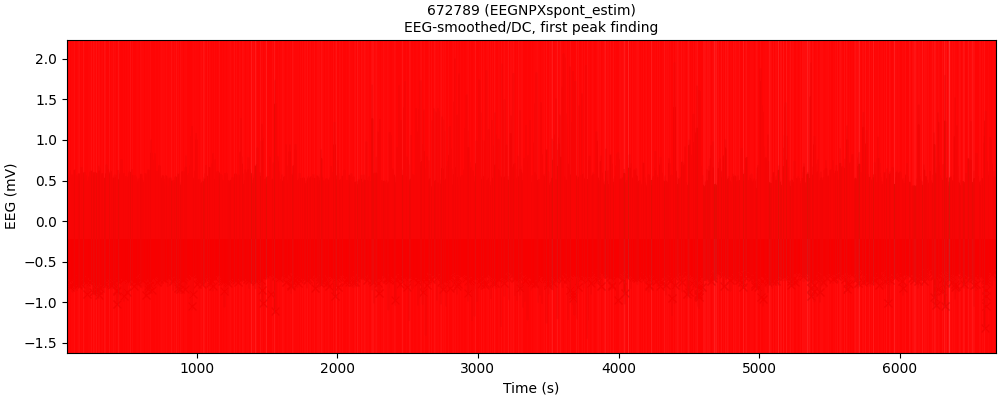

In [19]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(eeg_ts, eeg_data[:,test_ch], color='k', linewidth=1.0, alpha=0.3)
ax.plot(eeg_ts, DC_smooth_eeg, color='g', linewidth=1.5, alpha=0.8)
ax.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-smoothed/DC, first peak finding'.format(exp.mouse, exp_tag))
# ax.axhline(-peak_threshold, color='r', linewidth=1.0, alpha=0.8)
ax.plot(eeg_ts[pks_smdata], DC_smooth_eeg[pks_smdata], 'cx')
for pki in pruned_pk_times:
    ax.axvline(pki, color='r', linewidth=0.5, alpha=0.2)

In [19]:
## Group the peaks into potential events ##
possible_SWD_events = group_peaks(pruned_pk_times)
print(len(possible_SWD_events))

4974


Exclude possible SWD events and stim times from "quiescent times" to get new peak threshold

In [20]:
quiescent_signal = DC_smooth_eeg.copy()
print(quiescent_signal.size)

16506880


In [21]:
## Remove stim sessions from signal ##
if stim_log is not None:
    for sweepi in np.unique(stim_log.sweep.values):
        sweepdf = stim_log[stim_log['sweep'] == sweepi]
        for stimtype in np.unique(sweepdf.stim_type.values):
            stimdf = sweepdf[sweepdf['stim_type'] == stimtype]
            stiminds = np.nonzero((eeg_ts > stimdf.onset.values[0]) & (eeg_ts < stimdf.offset.values[-1]))[0]
            quiescent_signal[stiminds] = np.nan
print(np.sum(np.isnan(quiescent_signal)))

8478822


In [22]:
## Remove possible SWDs from signal ##
for spikelist in possible_SWD_events:
    if len(spikelist) > 2: # selects possible events with more than 2 peaks
        eventinds = np.nonzero((eeg_ts > spikelist[0] - 0.2) & (eeg_ts < spikelist[-1] + 0.2))[0] # buffer possible SWD by 0.5 before/after
        quiescent_signal[eventinds] = np.nan
print(np.sum(np.isnan(quiescent_signal)))

13723663


In [27]:
std_mult = 2
sm_data_thresh = np.nanmean(quiescent_signal) + (std_mult * np.nanstd(quiescent_signal))
print('Smoothed data threshold: {:.2f} mV'.format(sm_data_thresh))
## Find the first round of peaks ##
pks_smdata, _ = signal.find_peaks(-DC_smooth_eeg, sm_data_thresh)
print(len(pks_smdata))
## Prune the double+ peaks ##
pruned_pk_times = prune_close_peaks(eeg_ts[pks_smdata], -(DC_smooth_eeg[pks_smdata]))
print(len(pruned_pk_times))

Smoothed data threshold: 0.24 mV
67205
26027


In [28]:
## Group the peaks into potential events ##
possible_SWD_events = group_peaks(pruned_pk_times)
print(len(possible_SWD_events))
## Get the final event list ##
SWD_df = events_to_SWDdf(possible_SWD_events)
print(len(SWD_df))

4246
1492


In [29]:
SWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,79.484054,84.957633,5.473579,29,"[79.4840539774723, 79.60765349850155, 79.77245..."
1,85.869629,90.738810,4.869181,30,"[85.86962923220001, 86.0768284292652, 86.24442..."
2,91.504007,93.058801,1.554794,10,"[91.50400739795386, 91.69640665237155, 91.8776..."
3,95.671191,97.505584,1.834393,10,"[95.67119124935408, 95.82519065257823, 95.9931..."
4,98.406381,99.425977,1.019596,6,"[98.40638064999479, 98.71757944404253, 98.8867..."


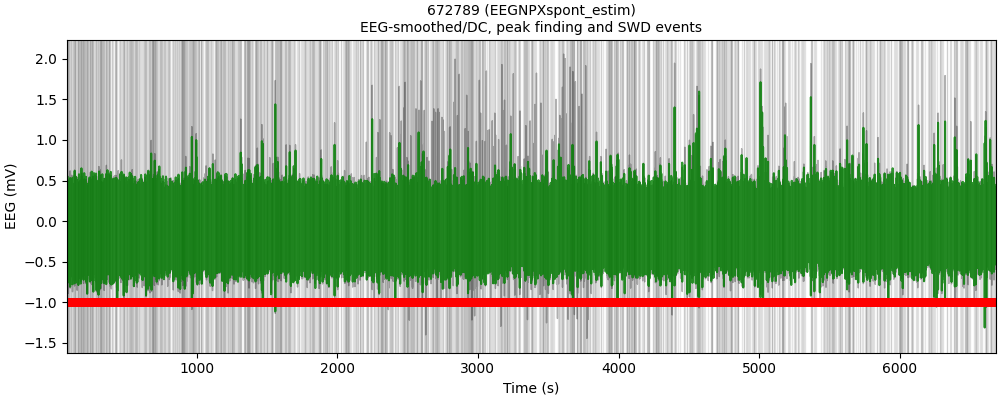

In [26]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(eeg_ts, eeg_data[:,test_ch], color='k', linewidth=1.0, alpha=0.3)
ax.plot(eeg_ts, DC_smooth_eeg, color='g', linewidth=1.5, alpha=0.8)
ax.set_xlim([eeg_ts[0], eeg_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-smoothed/DC, peak finding and SWD events'.format(exp.mouse, exp_tag))
ax.plot(pruned_pk_times, -np.ones((len(pruned_pk_times))), 'rx')

for dfind, dfrow in SWD_df.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], color='k', alpha=0.1)

In [30]:
for dfind, dfrow in SWD_df.iterrows():
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.7, 1.0, color='b', alpha=0.1)

The second round of peak finding works well with a threshold of mean + (3 * std). Need to add in some exclusion of stim times, but otherwise I'm happy with this automated process. Perhaps to be followed by a manual check/adjustment with MNE?
<br>I want to build the SWD event function to take in a 1D voltage signal array (so I can pass it EEG or LFP as needed) and output the SWD events dataframe.

# Older method

In [6]:
def peaks_to_events(test_signal, test_time, peak_threshold):
    pks, pks_info = signal.find_peaks(test_signal, peak_threshold)
    peak_times = test_time[pks]
    pk_preISIs = np.insert(np.diff(peak_times), 0, peak_times[0] - test_time[0])
    ## Loop through all peaks to find possible events ##
    event_list = []
    pkind = 0
    while pkind < len(peak_times):
        tempevent = [peak_times[pkind]]
        pkind += 1
        while (pkind < len(pk_preISIs)) and (pk_preISIs[pkind] < 0.4):
            tempevent.append(peak_times[pkind])
            pkind += 1
        if len(tempevent) > 1:
            event_list.append(tempevent)
        del tempevent
    return event_list

def annotate_SWDs(EEGsignal_exch, EEGtime, samplerate, filtfreqs=[3, 50], testslice=[0, 300]):
    ## Apply a bandpass filter to the whole signal ##
    bpb, bpa = signal.butter(3, np.array(filtfreqs)/(samplerate/2), btype='bandpass')
    filt_data = signal.filtfilt(bpb, bpa, EEGsignal_exch, axis=0)
    
    ## Start by using testslice to define a temporary threshold ##
    ## Identify possible SWDs so we can use quiescent times to define a better spike detection threshold ##
    slice_inds = np.nonzero((EEGtime > EEGtime[0] + testslice[0]) & (EEGtime < EEGtime[0] + testslice[1]))[0]
    timex = EEGtime[slice_inds]
    filtslice = filt_data[slice_inds]
    print('First threshold: {:.2f} mV'.format(np.mean(filtslice) + 2 * np.std(filtslice)))
    temp_event_list = peaks_to_events(-filtslice, timex, peak_threshold=np.mean(filtslice) + 2 * np.std(filtslice))
    ## Get quiescent times ##
    prob_events = []
    for evlist in temp_event_list:
        prob_events.append([evlist[0], evlist[-1]])
    prob_events_df = pd.DataFrame(prob_events, columns=['onset', 'offset'])
    
    ## Next, get quiescent times and more strict threshold ##
    adj_onsets = prob_events_df['onset'].values - 1
    adj_offsets = prob_events_df['offset'].values + 1
    qints = np.nonzero((adj_onsets[1:] - adj_offsets[:-1]) > 2)[0]
    qsigs = []
    for indi in qints:
        tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
        qsigs.append(filtslice[tempinds])
    qeeg = np.concatenate(qsigs)
    
    ## Identify events using new threshold ##
    print('Second threshold: {:.2f} mV'.format(np.mean(qeeg) + 3 * np.std(qeeg)))
    new_event_list = peaks_to_events(-filt_data, EEGtime, peak_threshold=np.mean(qeeg) + 3 * np.std(qeeg))
    SWD_info = []
    for spklist in new_event_list:
        if spklist[-1] - spklist[0] > 0.5:
            SWD_info.append([spklist[0], spklist[-1], spklist[-1]-spklist[0], len(spklist), spklist])
    SWD_df = pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])
    print('Found {:d} SWD events.'.format(len(SWD_df)))
    return SWD_df

### Load manual annotations

In [11]:
man_annot_file = os.path.join(exp.data_folder, r'manual_SWD_annots_first5min.csv')
if os.path.exists(man_annot_file):
    print(r'Whoop there it is')
    man_annots = pd.read_csv(man_annot_file)
else:
    print(r'Oops, no')

Whoop there it is


In [12]:
man_annots.head()

,onset,duration,description,offset
0,124.445446,0.631011,SWD,125.076457
1,125.183503,0.585939,maybe,125.769442
2,127.418704,4.079036,SWD,131.497740
3,139.383471,1.357801,SWD,140.741272
4,140.915927,0.771862,maybe,141.687789


## Test auto-detect function

In [13]:
ex_ch = 18
start = time.time()
autoSWD_df = annotate_SWDs(
    eeg_data[:,ex_ch], eeg_ts, samplerate=exp.ephys_params['EEG']['sample_rate'], filtfreqs=[3, 50], testslice=[0, 300]
)
end = time.time()
print('Time for auto detection: {:.1f} s'.format(end-start))

First threshold: 0.44 mV
Second threshold: 0.32 mV
Found 682 SWD events.
Time for auto detection: 0.4 s


In [14]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.198922,125.046523,0.847601,6,"[124.19892151478749, 124.46732186149704, 124.5..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,144.911348,148.291353,3.380004,22,"[144.91134827032755, 145.11654853539758, 145.4..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


## Below tests methods that went into the above functions

### Slice EEG to work with manually annotated 5 min chunk

In [15]:
end_slice = man_annots['offset'].values[-1] + 2.
slice_inds = np.nonzero(eeg_ts < end_slice)[0]

timex = eeg_ts[slice_inds]
eeg_slice = eeg_data[slice_inds, :]

### Apply bandpass filter

In [16]:
bpb, bpa = signal.butter(3, np.array([3, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_slice, axis=0)

<IPython.core.display.Javascript object>


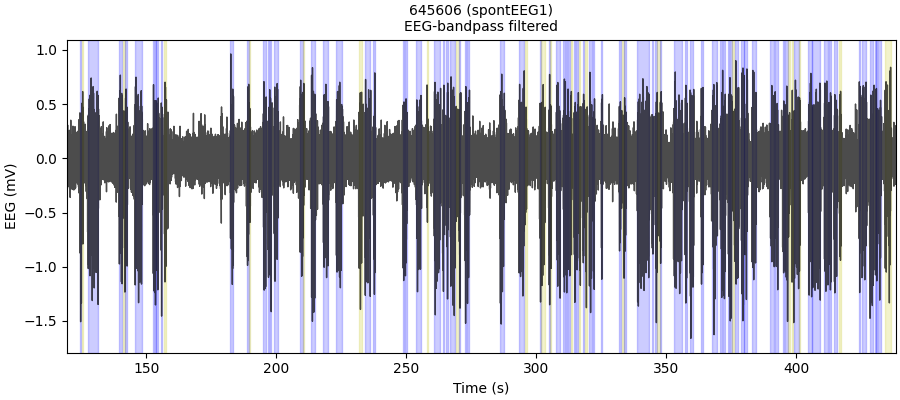

In [17]:
plot_ch = 18

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0, alpha=0.7)
# ax.plot(timex, filt_data[:, 16], color='b', linewidth=1.0, alpha=0.7)
# ax.plot(timex, np.std(filt_data, axis=1), color='r', linewidth=1.0, alpha=0.7)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], color=evcol, alpha=0.2)

<IPython.core.display.Javascript object>


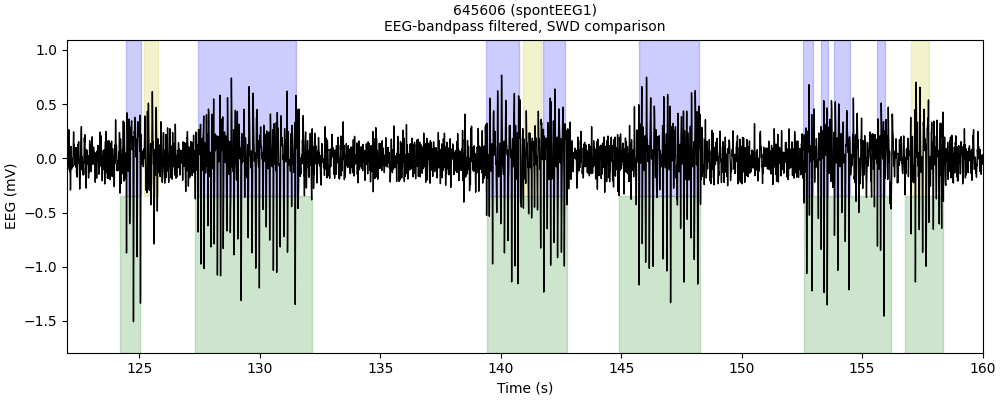

In [22]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([122, 160])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, SWD comparison'.format(exp.mouse, exp_tag))

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind, swdrow in autoSWD_df.iterrows():
    ax.axvspan(swdrow['onset'], swdrow['offset'], 0, 0.5, color='g', alpha=0.2)

### SAVE ###
fig_name = '{}_filtEEG_SWDs_ch{:d}.png'.format(exp_tag, plot_ch)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

#### Define quiescent periods

In [23]:
adj_onsets = man_annots['onset'].values - 1
print(adj_onsets[:5])
adj_offsets = man_annots['offset'].values + 1
print(adj_offsets[:5])

[123.44544552 124.18350321 126.41870389 138.38347121 139.91592688]
[126.07645668 126.76944214 132.49774028 141.741272   142.68778874]


In [24]:
between_times = adj_onsets[1:] - adj_offsets[:-1]
print(between_times[:10])

[-1.89295346 -0.35073825  5.88573093 -1.82534513 -1.92112361  1.05626028
  2.3393102  -1.66195831 -1.75773679 -0.87319437]


In [25]:
qints = np.nonzero(between_times > 2)[0]
print(qints)
print(len(qints))

[ 2  6 11 12 14 18 23 26 38 39 41 58 61 66 80 94]
16


<IPython.core.display.Javascript object>


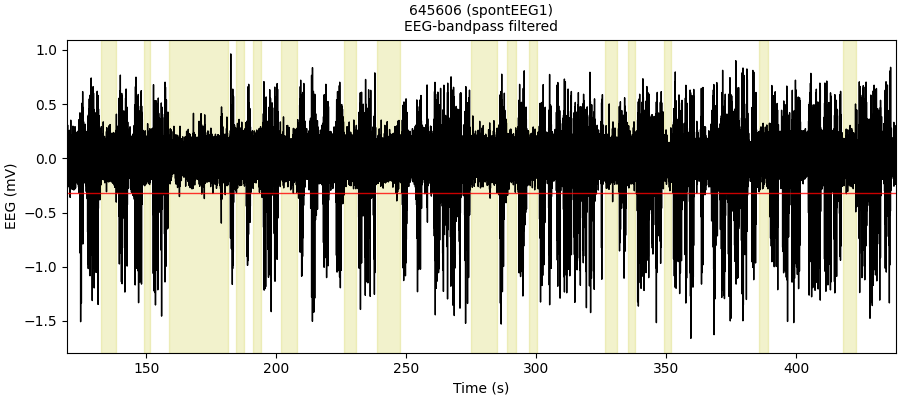

In [26]:
plot_ch = 18

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered'.format(exp.mouse, exp_tag))

notSWD_eegch = []
for indi in qints:
    ax.axvspan(adj_offsets[indi], adj_onsets[indi+1], color='y', alpha=0.2)
    tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
    notSWD_eegch.append(filt_data[tempinds, plot_ch])
quiesc_eeg = np.concatenate(notSWD_eegch)
q_mean = np.mean(quiesc_eeg)
q_std = np.std(quiesc_eeg)
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)

In [27]:
print(q_mean)
print(q_std)
print((q_mean + 3 * q_std))

7.994619464470531e-05
0.10663339737689935
0.3199801383253427


In [23]:
V_mean = np.mean(filt_data[:, plot_ch])
V_std = np.std(filt_data[:, plot_ch])
print(V_mean)
print(V_std)
print((V_mean + 2 * V_std))

-5.275326794419075e-06
0.22043726085555287
0.44086924638431135


### Can we use an auto threshold to find possible SWDs/quiescent periods to set a better threshold?

In [34]:
V_mean = np.mean(filt_data[:, plot_ch])
V_std = np.std(filt_data[:, plot_ch])
first_pkth = V_mean + 2 * V_std
first_peaks, pk_info = signal.find_peaks(-filt_data[:, plot_ch], first_pkth)
print(len(first_peaks))

774


Use initial threshold to find probable SWDs

In [38]:
spike_times = timex[first_peaks]

preISIs = np.insert(np.diff(spike_times), 0, spike_times[0] - timex[0])
postISIs = np.diff(spike_times)

## Loop through all spikes to find possible SWDs ##
SWD_list = []
spind = 0
while spind < len(spike_times):
    tempSWD = [spike_times[spind]]
    spind += 1
    while (spind < len(preISIs)) and (preISIs[spind] < 0.4):
        tempSWD.append(spike_times[spind])
        spind += 1
    if len(tempSWD) > 1:
        SWD_list.append(tempSWD)
    del tempSWD
print(len(SWD_list))

## Make dataframe ##
prob_SWD_info = []
for swdind in SWD_list:
    if swdind[-1]-swdind[0] > 0.5:
        prob_SWD_info.append([swdind[0], swdind[-1], swdind[-1]-swdind[0], len(swdind)])
prob_SWD_df = pd.DataFrame(prob_SWD_info, columns=['onset', 'offset', 'duration', 'spike count'])
prob_SWD_df.head()

77


,onset,offset,duration,spike count
0,124.467322,125.046523,0.579201,5
1,127.442926,131.586531,4.143605,29
2,139.412941,142.639745,3.226804,24
3,145.746149,146.320150,0.574001,5
4,147.466152,148.176552,0.710401,6


Find quiescent periods

In [39]:
adj_onsets = prob_SWD_df['onset'].values - 1
print(adj_onsets[:5])
adj_offsets = prob_SWD_df['offset'].values + 1
print(adj_offsets[:5])
between_times = adj_onsets[1:] - adj_offsets[:-1]
print(between_times[:10])
qints = np.nonzero(between_times > 2)[0]
print(len(qints))

[123.46732186 126.44292571 138.41294117 144.74614935 146.46615157]
[126.04652261 132.58653106 143.63974534 147.32015009 149.17655249]
[ 0.3964031   5.82641011  1.10640401 -0.85399852  2.52400584 -0.94239863
 -1.16639892 22.12883117  3.04000651  3.1868067 ]
17


Now find new threshold between probable SWDs

<IPython.core.display.Javascript object>


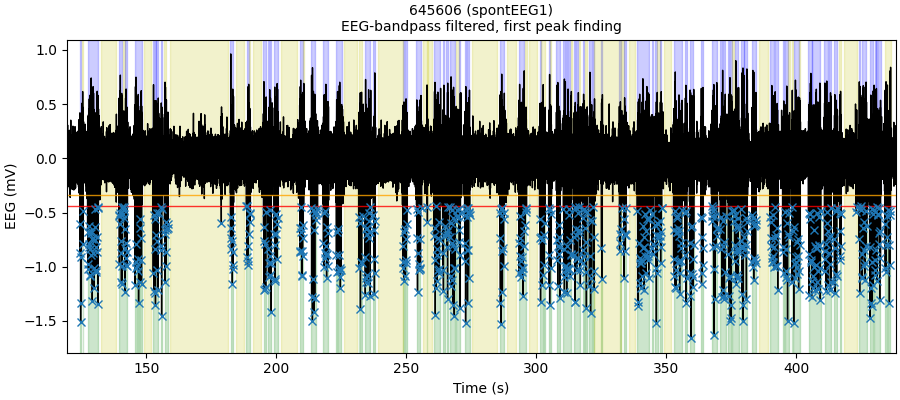

In [41]:
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, first peak finding'.format(exp.mouse, exp_tag))
ax.axhline(V_mean - 2 * V_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[first_peaks], filt_data[first_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)

for swdind in SWD_list:
    ax.axvspan(swdind[0], swdind[-1], 0, 0.5, color='g', alpha=0.2)

notSWD_eegch = []
for indi in qints:
    ax.axvspan(adj_offsets[indi], adj_onsets[indi+1], color='y', alpha=0.2)
    tempinds = np.nonzero((timex > adj_offsets[indi]) & (timex < adj_onsets[indi+1]))[0]
    notSWD_eegch.append(filt_data[tempinds, plot_ch])
qeeg = np.concatenate(notSWD_eegch)
q_mean = np.mean(qeeg)
q_std = np.std(qeeg)
ax.axhline(q_mean - 3 * q_std, color='orange', linewidth=1.0, alpha=0.8)

In [42]:
print(q_mean)
print(q_std)
print(q_mean + 3 * q_std)

5.429857950686579e-05
0.1139228936283384
0.34182297946452206


### Find peaks using quiescent voltage threshold (qVmean - 3 * qVstd)

In [28]:
pkthresh = q_mean + 3 * q_std

In [29]:
poss_peaks, pk_info = signal.find_peaks(-filt_data[:, plot_ch], height=pkthresh)
print(len(poss_peaks))

1012


<IPython.core.display.Javascript object>


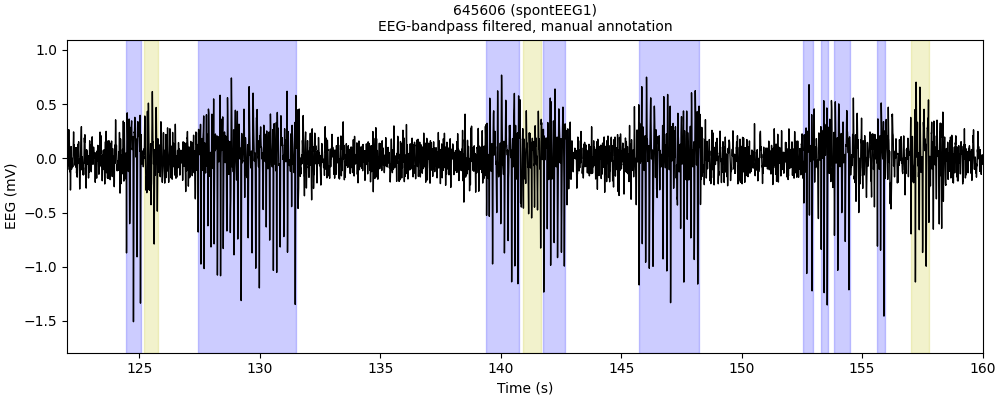

In [36]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([122, 160])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, peak finding'.format(exp.mouse, exp_tag))
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[poss_peaks], filt_data[poss_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], color=evcol, alpha=0.2)

### SAVE ###
fig_name = '{}_filtEEG_ch{:d}_peaks.png'.format(exp_tag, plot_ch)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

What if we iterate through all spikes?

In [46]:
# from above #
spike_times = timex[poss_peaks]

preISIs = np.insert(np.diff(spike_times), 0, spike_times[0] - timex[0])
postISIs = np.diff(spike_times)

In [47]:
## Loop through all spikes to find possible SWDs ##
SWD_list = []
spind = 0
while spind < len(spike_times):
    tempSWD = [spike_times[spind]]
    spind += 1
    while (spind < len(preISIs)) and (preISIs[spind] < 0.4):
        tempSWD.append(spike_times[spind])
        spind += 1
    if len(tempSWD) > 1:
        SWD_list.append(tempSWD)
    del tempSWD
print(len(SWD_list))

64


<IPython.core.display.Javascript object>


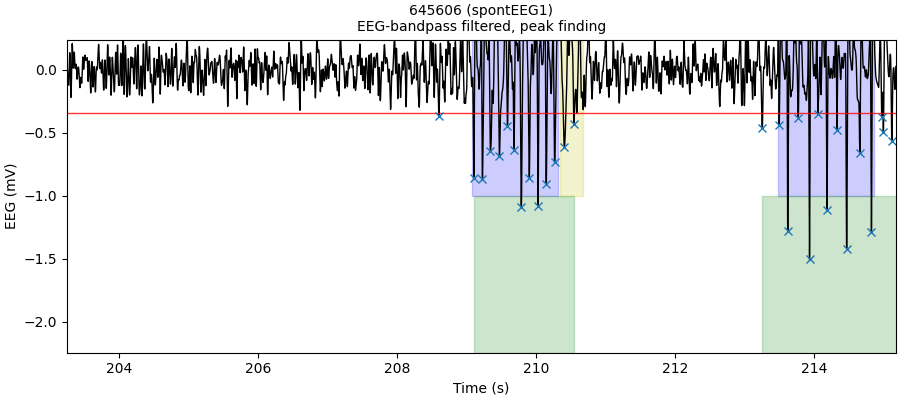

In [48]:
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex, filt_data[:, plot_ch], color='k', linewidth=1.0)
ax.set_xlim([timex[0], timex[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG (mV)')
ax.set_title('{} ({})\nEEG-bandpass filtered, peak finding'.format(exp.mouse, exp_tag))
ax.axhline(q_mean - 3 * q_std, color='r', linewidth=1.0, alpha=0.8)
ax.plot(timex[poss_peaks], filt_data[poss_peaks, plot_ch], 'x')

for dfind, dfrow in man_annots.iterrows():
    if dfrow['description'] == 'SWD':
        evcol = 'b'
    elif dfrow['description'] == 'maybe':
        evcol = 'y'
    ax.axvspan(dfrow['onset'], dfrow['offset'], 0.5, 1, color=evcol, alpha=0.2)
    
for swdind in SWD_list:
    ax.axvspan(swdind[0], swdind[-1], 0, 0.5, color='g', alpha=0.2)

### Make SWD event table

In [50]:
SWD_info = []
for swdind in SWD_list:
    if swdind[-1]-swdind[0] > 0.5:
        SWD_info.append([swdind[0], swdind[-1], swdind[-1]-swdind[0], len(swdind), swdind])
SWD_df = pd.DataFrame(SWD_info, columns=['onset', 'offset', 'duration', 'spike_count', 'SWD_spike_times'])
SWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.467322,125.046523,0.579201,5,"[124.46732186149704, 124.59812203045982, 124.7..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,145.409749,148.291353,2.881604,20,"[145.40974891414288, 145.6253491926473, 145.74..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


In [57]:
auto_annot_file = os.path.join(exp.data_folder, r'test_autoSWDannots_first5min.pkl')
SWD_df.to_pickle(auto_annot_file)

## Must save df as a pickle file to recover the list of spike times

In [58]:
if os.path.exists(auto_annot_file):
    print(r'Whoopee')
    test_annots = pd.read_pickle(auto_annot_file)
else:
    print(r'Oops, no')

Whoopee


In [59]:
test_annots.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,124.467322,125.046523,0.579201,5,"[124.46732186149704, 124.59812203045982, 124.7..."
1,127.321726,132.150932,4.829206,33,"[127.32172554870921, 127.44292570527105, 127.5..."
2,139.412941,142.752145,3.339204,26,"[139.4129411676904, 139.52534131288473, 139.66..."
3,145.409749,148.291353,2.881604,20,"[145.40974891414288, 145.6253491926473, 145.74..."
4,152.581758,156.198563,3.616805,23,"[152.58175817867686, 152.70055833213848, 152.8..."


In [61]:
test_val = test_annots['onset'].values[0]
print(test_val)
print(type(test_val))

124.46732186149704
<class 'numpy.float64'>
